# Tensor contraction and regression layers in keras / tensorflow

## Introduction

A tensor regression layer (TRL) is a drop-in replacement for fully connected layers in classification networks. It can be trained in an end-to-end fashin and **reduces number of parameters** without the decrease in classification accuracy. Moreover, using TRL **preserves the multilinear (spatial) information** that is otherwise lost during the flattening or global pooling operation, typically used before the fully connected networks. 

Here, I develop a Keras/Tensorflow implementation of the TRL, based on an example in PyTorch. 

Its use if exemplified in training a simple CNN for (fashion) MNIST classification. 

## Referebnces:

- Kossaifi et al. (2017) [Tensor Contraction Layers for Parsimonious Deep Nets](https://arxiv.org/abs/1706.00439), ArXiv.
- Kossaifi et al. (2017) [Tensor Regression Networks](https://arxiv.org/abs/1707.08308), ArXiv.

## Source code:
- [TRL in tensorly and pytorch](https://github.com/JeanKossaifi/tensorly-notebooks/blob/master/05_pytorch_backend/tensor_regression_layer_pytorch.ipynb), GitHub.
- [TCL in numpy](https://anishshah.github.io/ml/2017/06/13/TCL.html), Anish Shah.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorly as tl
print(tl.__version__)
tl.set_backend('tensorflow')
from tensorly.tenalg import inner
from tensorly.random import check_random_state

Using numpy backend.
Using tensorflow backend.


0.4.3


# TensorContractionLayer in Keras

In [2]:
from tensorflow.python import keras as K
from tensorflow.keras.layers import Layer
    
class TensorContractionLayer(Layer):
    '''Tensor Contraction Layer.
     
    Reference: Jean Kossaifi et al, [Tensor Contraction and Regression Networks](https://arxiv.org/abs/1707.08308), arXiv, 2018.
    
    '''
    import tensorly as tl
    tl.set_backend('tensorflow')
    
    def __init__(self, output_shape, verbose=1, **kwargs):
        super(TensorContractionLayer, self).__init__(**kwargs)
        self.verbose = verbose
        self.factors = []
        if output_shape[0] == None: 
            output_shape = output_shape[1:]
        self.output_size = output_shape
        
            
    def build(self, input_shape):
        
        if isinstance(input_shape, int):
            self.input_size = [input_shape]
        else:
            self.input_size = list(input_shape)
        assert isinstance(self.input_size, list)
        assert len(self.output_size) == len(self.input_size)-1, 'TensorContractionLayer: output_shape must be of len(input_shape)-1 or starting with `None` to exclude batch size'
        

        # 
        weight_size = list(self.input_size[1:]) + list(self.output_size) # exclude batch axis
        self.factors = []
        for index, (in_size, rank) in enumerate(zip(weight_size, self.output_size)):
            factor = self.add_weight(name='factor_{}'.format(index),
                                     shape=(in_size, rank),
                                     initializer=tf.keras.initializers.uniform(-0.5, 0.5),
                                     trainable=True, dtype=tf.float32)
            self.factors.append(factor)

        print(f'self.factors.shape = {[f.shape.as_list() for f in self.factors]}, n_params = {[np.prod(f.shape.as_list()) for f in self.factors]} ')
        super(TensorContractionLayer, self).build(input_shape)  # Be sure to call this at the end

        
    def call(self, x):
        #print(f'INPUT shape = {x.shape}')
        for i, factor in enumerate(self.factors):
            x = tl.tenalg.contract(tensor1=factor, modes1=[0], tensor2=x, modes2=[i+1])
        output = tf.transpose(x, (3,2,1,0))
        #print(f'OUTPUT shape = {output.shape}')
        return output

    def compute_output_shape(self, input_shape):
        return tf.TensorShape((None, *self.output_size))
    
    def get_config(self):
        config = {
            'output_shape': self.output_size
        }
        base_config = super(TensorContractionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

        

Using tensorflow backend.


# TensorRegressionLayer in Keras

Based on: [TensorRegressionLayer in tensorly and pytorch](https://github.com/JeanKossaifi/tensorly-notebooks/blob/master/05_pytorch_backend/tensor_regression_layer_pytorch.ipynb)


In [3]:
from tensorflow.python import keras as K
from tensorflow.keras.layers import Layer

class TensorRegressionLayer(Layer):
    '''Tensor Regression Layer.
     
     Reference: Jean Kossaifi et al, [Tensor Regression Networks](https://arxiv.org/abs/1707.08308), arXiv, 2018.
    
    '''
    def __init__(self, ranks, output_shape, verbose=1, **kwargs):
        super(TensorRegressionLayer, self).__init__(**kwargs)
        self.ranks = list(ranks)
        self.verbose = verbose
        self.core = None
        self.factors = []
        self.bias = None
        self.n_outputs = None
        
        if isinstance(output_shape, int):
            self.output_size = [output_shape]
        else:
            self.output_size = list(output_shape)

                    
    def build(self, input_shape):
                    
        input_shape = list(input_shape)
        self.n_outputs = int(np.prod(self.output_size[1:])) # exclude batch axis
        
        # Core of the regression tensor weights
        self.core = self.add_weight(name='core',
                                    shape=self.ranks,
                                    initializer=tf.keras.initializers.uniform(-0.1, 0.1),
                                    trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(1,),
                                    initializer=tf.keras.initializers.constant(0.),
                                    trainable=True)
        
        weight_size = list(input_shape[1:]) + list(self.output_size[1:]) # exclude batch axis
        self.factors = []
        for index, (in_size, rank) in enumerate(zip(weight_size, self.ranks)):
            factor = self.add_weight(name='factor_{}'.format(index),
                                     shape=(in_size, rank),
                                     initializer=tf.keras.initializers.uniform(-0.1, 0.1),
                                     trainable=True)
            self.factors.append(factor)

        print(f'self.core.shape = {self.core.shape}, n_params = {np.prod(self.core.shape)}')
        print(f'self.factors.shape = {[f.shape.as_list() for f in self.factors]}, n_params = {[np.prod(f.shape.as_list()) for f in self.factors]} ')
        print(f'self.bias.shape = {self.bias.shape}, n_params = {np.prod(self.bias.shape)}')
        
        super(TensorRegressionLayer, self).build(input_shape)  # Be sure to call this at the end

        
    def call(self, x):
        regression_weights = tl.tucker_to_tensor(self.core, self.factors)
        return tl.tenalg.inner(x, regression_weights, n_modes=tl.ndim(x)-1) + self.bias
        
    def compute_output_shape(self, input_shape):
        return tf.TensorShape((None, self.n_outputs))
    
    def get_config(self):
        config = {
            'ranks': self.ranks,
            'output_shape': self.output_size
        }
        base_config = super(TensorRegressionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def penalty(self, order=2):
        penalty = tl.norm(self.core, order)
        for f in self.factors:
            penalty += tl.norm(f, order)
        return penalty
    
    
def TRL_loss(tensor_regression_layer, regularization_factor):
    def loss(y_true, y_pred):
        return K.losses.categorical_crossentropy(y_true, y_pred) + regularization_factor * tensor_regression_layer.penalty(order=2)
    return loss


# Model

- baseline CNN model wiht `Dense` layer

In [28]:
def get_baseline_model(input_shape, num_classes):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
    
    i = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(i)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    o = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=i, outputs=o)    
    
model1 = get_baseline_model((28,28,1), 10)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

- CNN model with tensor regression layer (`TRL`)

In [29]:
def get_TRL_model(input_shape, num_classes):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
    
    i = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(i)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    #x = TensorContractionLayer(output_shape=(None,3,3,32))(x)
    x = TensorRegressionLayer(ranks=(3,3,20,20), output_shape=(None, num_classes))(x)
    o = Activation('softmax')(x)
    return Model(inputs=i, outputs=o)    
    
model2 = get_TRL_model((28,28,1), 10)
model2.summary()

self.core.shape = (3, 3, 20, 20), n_params = 3600
self.factors.shape = [[5, 3], [5, 3], [64, 20], [10, 20]], n_params = [15, 15, 1280, 200] 
self.bias.shape = (1,), n_params = 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (

Note the difference in the number of parameter of both models:

In [30]:
print(f'Model with TRL layer has only {model2.count_params() / model1.count_params():.2%} number of params of model with Dense layer')

Model with TRL layer has only 10.63% number of params of model with Dense layer


# Load (fashion) MNIST data

In [31]:
dataset = 'fashion mnist' # 'mnist'  or 'fashion mnist'

from tensorflow.python import keras as K
if dataset=='mnist':
    from tensorflow.keras.datasets import mnist as data
    num_classes = 10
elif dataset == 'fashion mnist':
    from tensorflow.keras.datasets import fashion_mnist as data
    num_classes = 10
    
batch_size = 2048
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = K.utils.to_categorical(y_train, num_classes)
y_test = K.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Train baseline model

In [32]:
%%time
print(f'CNN model with Dense layer, number of parameters: {model1.count_params():,}')

model1.compile(loss=K.losses.categorical_crossentropy,
              optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              metrics=['accuracy'])

history1 = model1.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))


CNN model with Dense layer, number of parameters: 225,034
Epoch 1/50
30/30 [==============================] - 1s 46ms/step - loss: 1.2726 - acc: 0.5633 - val_loss: 0.7079 - val_acc: 0.7381
Epoch 2/50
30/30 [==============================] - 1s 46ms/step - loss: 0.6632 - acc: 0.7526 - val_loss: 0.5566 - val_acc: 0.7927
Epoch 3/50
30/30 [==============================] - 1s 46ms/step - loss: 0.5504 - acc: 0.7966 - val_loss: 0.4931 - val_acc: 0.8200
Epoch 4/50
30/30 [==============================] - 1s 46ms/step - loss: 0.4913 - acc: 0.8209 - val_loss: 0.4472 - val_acc: 0.8367
Epoch 5/50
30/30 [==============================] - 1s 47ms/step - loss: 0.4530 - acc: 0.8350 - val_loss: 0.4223 - val_acc: 0.8461
Epoch 6/50
30/30 [==============================] - 1s 47ms/step - loss: 0.4261 - acc: 0.8466 - val_loss: 0.3963 - val_acc: 0.8594
Epoch 7/50
30/30 [==============================] - 1s 49ms/step - loss: 0.4055 - acc: 0.8524 - val_loss: 0.3821 - val_acc: 0.8607
Epoch 8/50
30/30 [=======

# Train TRL model

In [33]:
print(f'CNN model with TRL, number of parameters: {model2.count_params():,}')

model2.compile(loss=TRL_loss(model2.layers[-2], regularization_factor=0.01), 
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01), # <- Note the 20x higher learning rate!
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))


CNN model with TRL, number of parameters: 23,927
Epoch 1/50
30/30 [==============================] - 2s 53ms/step - loss: 1.7667 - acc: 0.3607 - val_loss: 1.2229 - val_acc: 0.5661
Epoch 2/50
30/30 [==============================] - 2s 54ms/step - loss: 1.0267 - acc: 0.6602 - val_loss: 0.8569 - val_acc: 0.7375
Epoch 3/50
30/30 [==============================] - 2s 53ms/step - loss: 0.8057 - acc: 0.7516 - val_loss: 0.7709 - val_acc: 0.7710
Epoch 4/50
30/30 [==============================] - 2s 52ms/step - loss: 0.7477 - acc: 0.7801 - val_loss: 0.7262 - val_acc: 0.7915
Epoch 5/50
30/30 [==============================] - 2s 50ms/step - loss: 0.7188 - acc: 0.7979 - val_loss: 0.6976 - val_acc: 0.8172
Epoch 6/50
30/30 [==============================] - 2s 51ms/step - loss: 0.6941 - acc: 0.8136 - val_loss: 0.6748 - val_acc: 0.8299
Epoch 7/50
30/30 [==============================] - 2s 51ms/step - loss: 0.6793 - acc: 0.8246 - val_loss: 0.6714 - val_acc: 0.8311
Epoch 8/50
30/30 [================

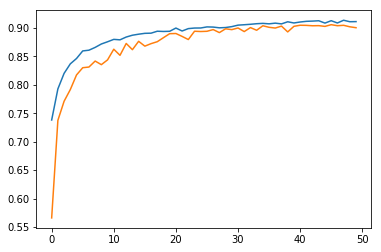

In [34]:
plt.plot(history1.history['val_acc'], label='Dense')
plt.plot(history2.history['val_acc'], label='TRL')

# Save / load model

In [35]:
model1.save('model_dense.h5')
model2.save('model_TRL.h5')

In [36]:
from tensorflow.keras.models import load_model
model3 = load_model('model_TRL.h5', custom_objects={'TensorContractionLayer': TensorContractionLayer, 
                                          'TensorRegressionLayer': TensorRegressionLayer})

self.core.shape = (3, 3, 20, 20), n_params = 3600
self.factors.shape = [[5, 3], [5, 3], [64, 20], [10, 20]], n_params = [15, 15, 1280, 200] 
self.bias.shape = (1,), n_params = 1


# Show predictions

In [37]:
def plot_images(x, y_pred=None, y_true=None, figsize=(10,10)):
    
    nr = int(np.ceil(np.sqrt(len(x))))
    fig, ax = plt.subplots(nr, nr, figsize=figsize, squeeze=False)
    fig.tight_layout()
    ax = ax.flatten()
    
    for i, im in enumerate(x):
        im = np.squeeze(im)
        ax[i].imshow(im, cmap='gray_r')
        
        title = ''
        if y_pred is not None: 
            y_pred_label = np.argmax(y_pred[i])
            title += f'{y_pred_label}'
        if y_true is not None:
            y_true_label = np.argmax(y_true[i])
            title += f' ({y_true_label})'
        ax[i].set_title(title, color='black')
        
        if y_pred is not None and y_true is not None:
            if y_pred_label != y_true_label:
                #print(y_pred_label, y_true_label)
                ax[i].imshow(im, cmap='Reds_r')
                ax[i].set_title(title, color='red', fontweight="bold")
        ax[i].axis('off')

    for a in ax[i+1:]: a.set_visible(False)
        
def failure_cases(x, y_pred, y_true):
    indices = np.where(np.argmax(y_pred, -1) != np.argmax(y_test, -1))[0]
    return indices

In [38]:
model1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step


[0.24151877546906472, 0.9109]

In [39]:
model2.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step


[0.6235483496665954, 0.9002]

In [40]:
#timeit 
y_pred1 = model1.predict(x_test)

In [41]:
#timeit 
y_pred2 = model2.predict(x_test)

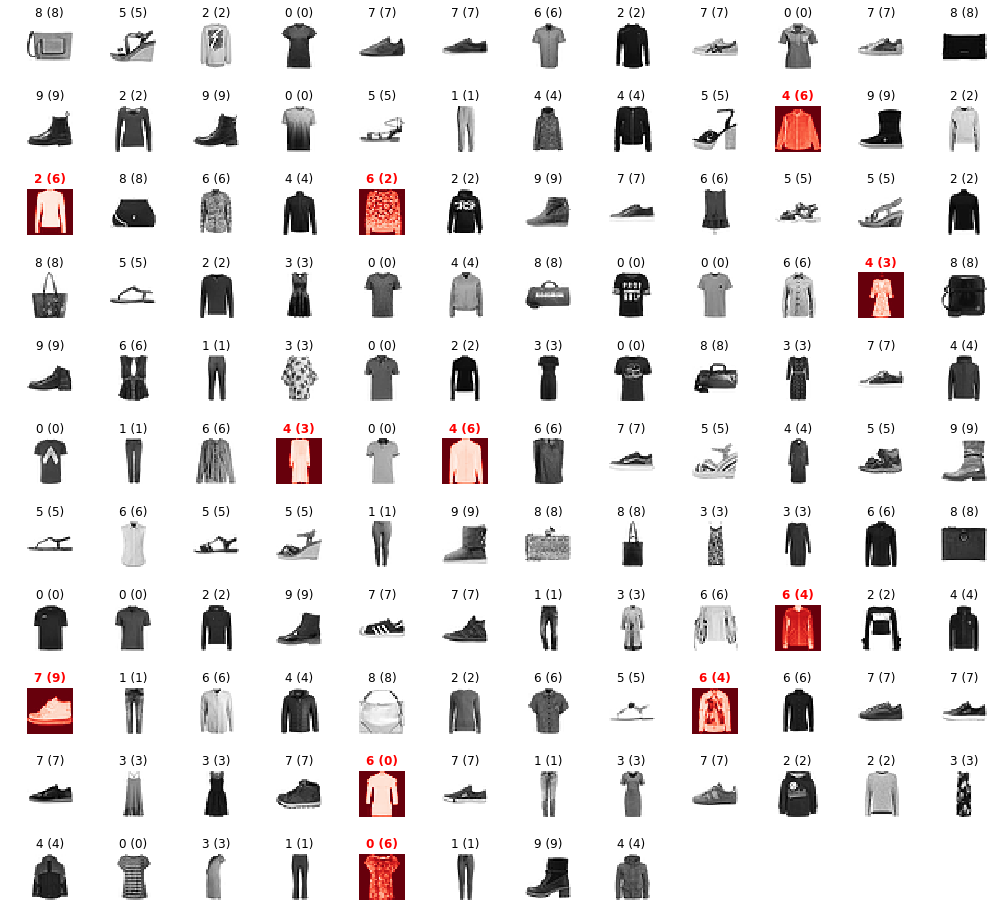

In [42]:
start=220
end=start+128
plot_images(x=x_test[start:end], y_pred=y_pred1[start:end], y_true=y_test[start:end], figsize=(14,14))

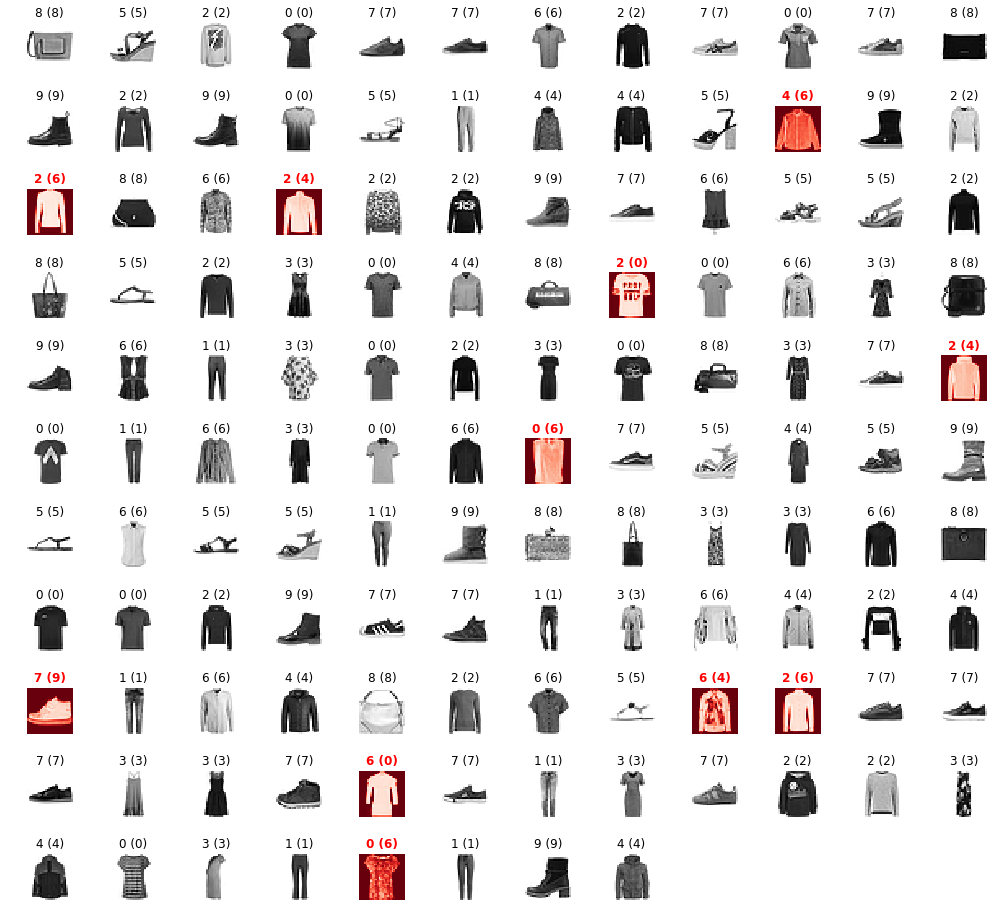

In [43]:
plot_images(x=x_test[start:end], y_pred=y_pred2[start:end], y_true=y_test[start:end], figsize=(14,14))

---

In [44]:
failures1 = failure_cases(x_test, y_pred1, y_test)    
len(failures1)

891

In [45]:
failures2 = failure_cases(x_test, y_pred2, y_test)
len(failures2)

998

In [46]:
common_failures = list(set(failures1) - set(failures2))
common_failures = common_failures[:128]

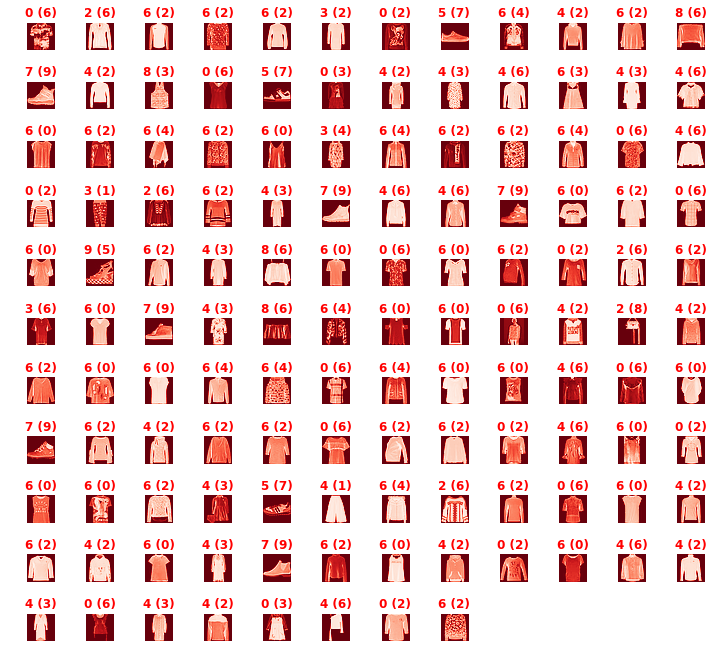

In [47]:
plot_images(x=x_test[common_failures], y_pred=y_pred1[common_failures], y_true=y_test[common_failures])

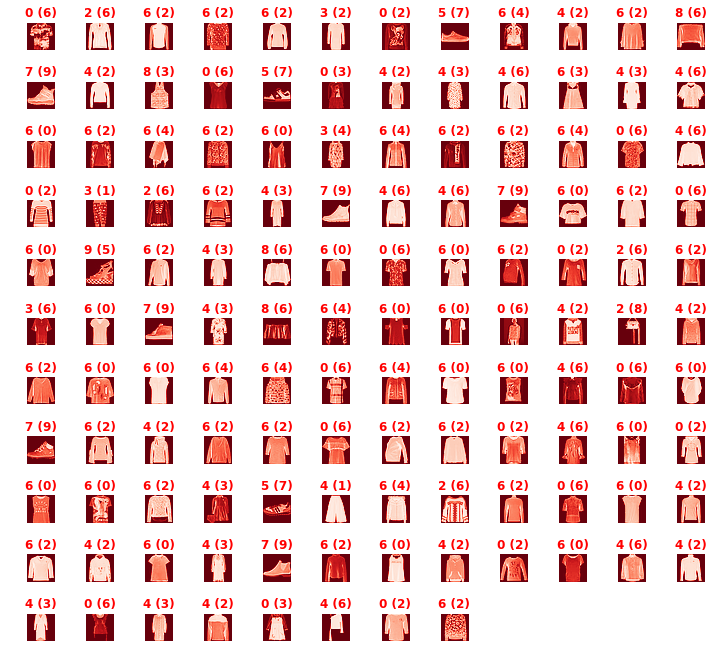

In [48]:
plot_images(x=x_test[common_failures], y_pred=y_pred1[common_failures], y_true=y_test[common_failures])